# Budget Analysis V1

This is my second attempt at viewing my spending data. In `v0`, we explored how to deduplicate the data across `*.csv` files for when I arbitrarily download multiple files. First, I'm going to construct all the AI generated code into the block below.

In [1]:
import finance_cleaner as fc

df = fc.clean_transactions("../data/transactions_*.csv")
df.to_csv('../data/finance_cleaner_output.csv')


=== READING IN FILES ===

✅ Read in frame transactions_2025_06_13.csv with shape (1988, 9)
✅ Read in frame transactions_dummy_to_test_duplicates.csv with shape (1988, 9)

=== CONVERTING TYPES ===

✅ Converted date string to_datetime
✅ Converted boolean strings to boolean
✅ Converted boolean strings to boolean
✅ Converted amount strings to numeric

=== ADDING ROW HASHES ===

✅ Created columns IntraKey, CrossKey, and RowID
✅ Set RowID as index

=== COALESCING DUPLICATES on key='CrossKey' ===

  Merging 2 rows for group '0a85a'. RowIDs: ['0a85a_1', '0a85a_2']
  Merging 2 rows for group '0dd4d'. RowIDs: ['0dd4d_1', '0dd4d_2']
  Merging 3 rows for group '0f0d5'. RowIDs: ['0f0d5_1', '0f0d5_2', '0f0d5_3']
  ... (remaining rows hidden)

✅ Total rows after de-duplication: 3885

=== REMOVING DUPLICATES on key='IntraKey' ===

  Removing 1939 duplicate rows:
  RowID: 47 | Date: 2025-02-10 00:00:00 | Desc: FID BKG SVC LLC DES MONEYLINE INDN LEN G HUANG CO PPD | Amt: -200.0
  RowID: 82 | Date: 2024

# LLM Integration

Let's do some set up so that we can use LLM's to parse and understand our CSV.

In [2]:
from openrouter import OpenRouterClient

# Set up the client
client = OpenRouterClient()

# Get first 5 rows as string
first_5_rows = df.head(5).to_string()

# Query LLM with budget expert system prompt
response = client.quick_query(
    first_5_rows,
    system_message="Provide a brief summary of this transaction data, with short sentences and bullet points"
)

print("\n=== Budget Analysis ===")
print(response)


=== Budget Analysis ===
Here is a summary of the transaction data:

*   **Source:** Multiple sources, including Bank of America and Venmo.
*   **Categories:** Includes transfers, energy/gas, rideshare, and income.
*   **Amounts:** Transactions range from -$400.00 to $97.57.
*   **Dates:** Transactions occurred between late January 2024 and early June 2025.
*   **Descriptions:** Provide details like transfer recipients and service providers.
*   **Other Details:**  Each transaction has an `Account`, some codes like `CrossKey` and  `IntraKey`,  and flags for `Is Hidden` and `Is Pending`.



# More Nuanced Category Understanding

With this in mind, we can seek to accomplish a more nuanced understanding of how we organize data. Rather than providing hardcoded regex rules, I seek to provide a list of human language rules that we can use to get more nuanced understandings of the data. I'm imagining something where we supply the unique values of descriptions x categories to an LLM, have it create smart categories, and then compare and contrast the pie charts for those.

In [3]:
import pandas as pd

# Load and prepare data
df = pd.read_csv('../data/finance_cleaner_output.csv')

# Exclude 'Transfers' category
df = df[df['Category'] != 'Transfers']

# Separate spending and income
spending = df[df['Amount'] < 0].copy()
income = df[df['Amount'] > 0].copy()

# Convert spending amounts to positive for analysis
spending['Amount'] = spending['Amount'].abs()

# Calculate spending and income by category (sorted ascending)
spending_by_category = spending.groupby('Category')['Amount'].sum().sort_values()
income_by_category = income.groupby('Category')['Amount'].sum().sort_values()

# Display the underlying data
print("=== SPENDING BY CATEGORY ===")
print(spending_by_category)
print("\n=== INCOME BY CATEGORY ===")
print(income_by_category)

# Calculate percentages
print("\n=== SPENDING PERCENTAGES ===")
print((spending_by_category / spending_by_category.sum() * 100).round(1))
print("\n=== INCOME PERCENTAGES ===")
print((income_by_category / income_by_category.sum() * 100).round(1))

=== SPENDING BY CATEGORY ===
Category
Pets                                2.50
Auto Service                        4.30
Education                           4.91
Bank Fee                            6.95
Health & Fitness                   16.00
Books                              19.09
Gifts                              20.00
Checks                             20.00
Gas & Fuel                         23.13
Tolls                              27.99
Household Services                 39.16
Personal Care                      52.53
Entertainment                      59.55
Auto & Transport                   65.00
Insurance                          79.41
Home Improvement/Maintenance       85.84
Electronics & Software             87.05
Taxes                              90.06
Pharmacy                          103.98
Concerts & Events                 108.86
Subscriptions                     138.93
Other                             146.29
Energy, Gas & Electric            146.32
Hair & Nails       

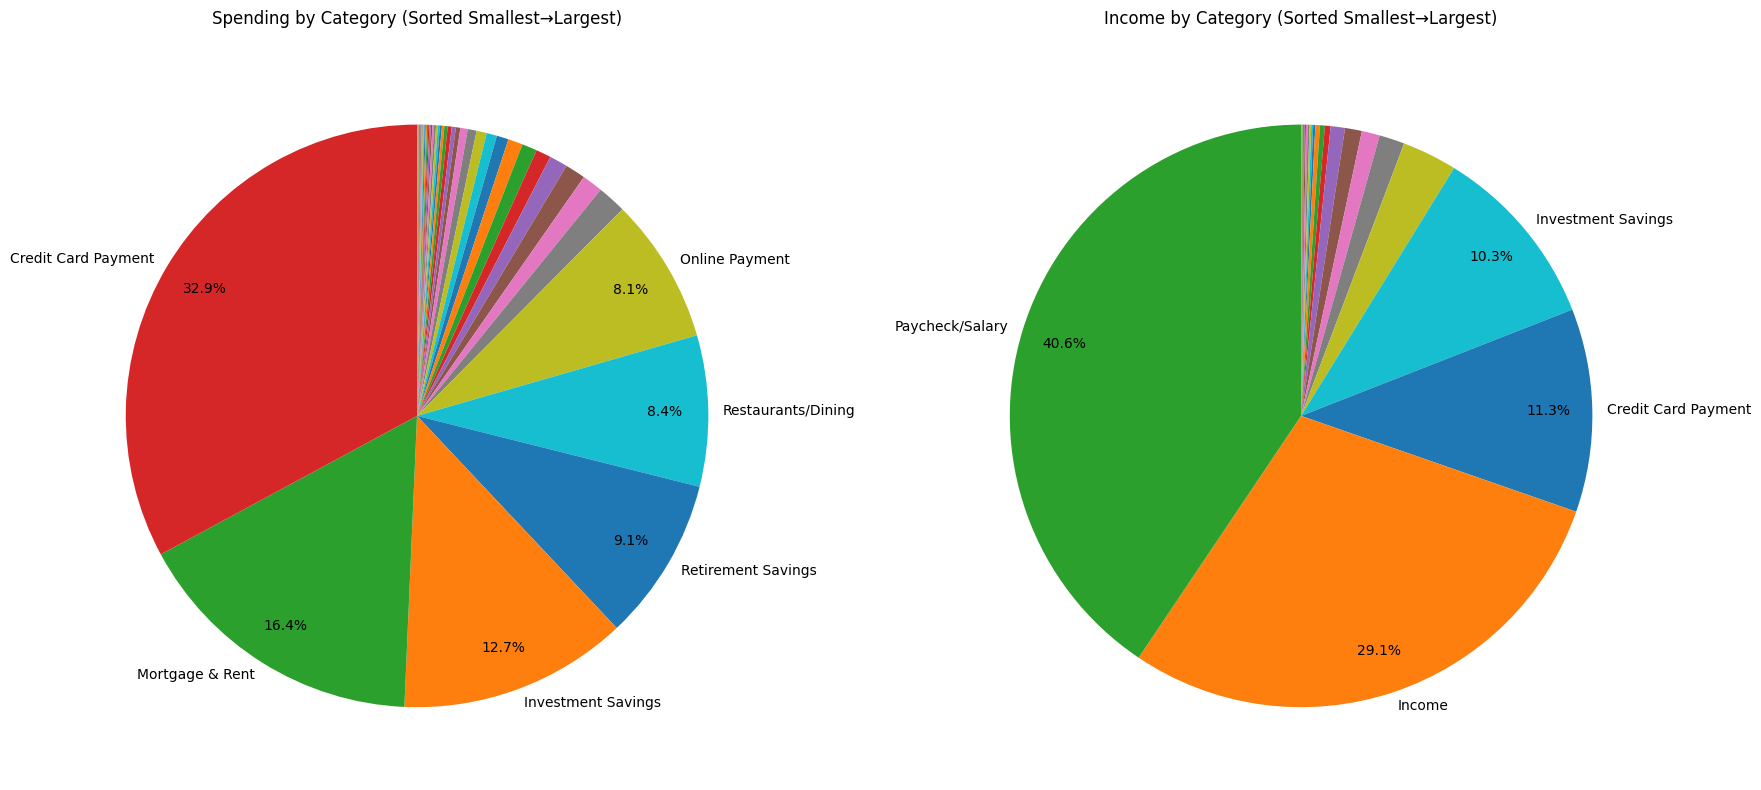

In [4]:
import matplotlib.pyplot as plt

def make_autopct(values):
    def my_autopct(pct):
        return '%1.1f%%' % pct if pct > 5 else ''
    return my_autopct

plt.figure(figsize=(18, 8))

# Spending pie chart
plt.subplot(1, 2, 1)
values = spending_by_category.values
labels = [label if (value/sum(values)*100) > 5 else ''
          for label, value in zip(spending_by_category.index, values)]

plt.pie(
    values,
    labels=labels,
    autopct=make_autopct(values),
    startangle=90,
    pctdistance=0.85,
    labeldistance=1.05,
    counterclock=False
)
plt.title('Spending by Category (Sorted Smallest→Largest)', pad=20)

# Income pie chart
plt.subplot(1, 2, 2)
values = income_by_category.values
labels = [label if (value/sum(values)*100) > 5 else ''
          for label, value in zip(income_by_category.index, values)]

plt.pie(
    values,
    labels=labels,
    autopct=make_autopct(values),
    startangle=90,
    pctdistance=0.85,
    labeldistance=1.05,
    counterclock=False
)
plt.title('Income by Category (Sorted Smallest→Largest)', pad=20)

plt.tight_layout()
plt.show()

From this, I'm making a few observations:
- I should coalesce credit card reversals into credit card spending rather than as true "income", as this may be misleading.
- I should add more detail to "income" because I'm not sure if that may be referring to Venmo payments.
- I should understand what "Retirement Savings" vs "Investment Savings" is as well, and how they may be different. They show up in both income and spending too.
- I have a long tail of "other" categories that need understanding too.

Let's try to provide the LLM some data about the various categories and weight it by amount.

In [5]:
# Load and prepare your data
df = pd.read_csv('../data/finance_cleaner_output.csv')

# Add transaction type and remove amount
df['TransactionType'] = df['Amount'].apply(lambda x: 'Income' if x > 0 else 'Spending')
df = df.drop('Amount', axis=1)

# Group and count transactions
grouped_df = df.groupby(['Account', 'Category', 'Description', 'Institution', 'TransactionType']).size().reset_index(name='Count')

# Calculate total counts for percentage calculation
total_transactions = len(df)
total_income = len(df[df['TransactionType'] == 'Income'])
total_spending = len(df[df['TransactionType'] == 'Spending'])

# Add percentage columns
grouped_df['PercentageOfTotal'] = (grouped_df['Count'] / total_transactions * 100).round(2)
grouped_df['PercentageOfType'] = grouped_df.apply(
    lambda row: round(row['Count'] / total_income * 100, 2) if row['TransactionType'] == 'Income'
    else round(row['Count'] / total_spending * 100, 2),
    axis=1
)

# Format percentages
grouped_df['PercentageOfTotal'] = grouped_df['PercentageOfTotal'].astype(str) + '%'
grouped_df['PercentageOfType'] = grouped_df['PercentageOfType'].astype(str) + '%'

# Sort results
grouped_df = grouped_df.sort_values('Count', ascending=False)

# Display
grouped_df

,Account,Category,Description,Institution,TransactionType,Count,PercentageOfTotal,PercentageOfType
61,Adv Plus Banking - 2082,Transfers,ALLY BANK DES TRANSFER INDN LEN G HUANG CO WEB,Bank of America - via Direct Web API,Spending,86,4.42%,6.49%
70,Ally Savings Account,Transfers,REQUESTED TRANSFER FROM LEN G HUANG ALLY BANK ...,Ally,Income,82,4.21%,13.23%
119,Biweekly Index Funds,Investment Savings,MONEY LINE RECEIVED EFT FUNDS RECEIVED,Fidelity Investments - via Fidelity Access,Income,41,2.11%,6.61%
312,Other Spending,Groceries,TRADER JOES,Chase,Spending,40,2.06%,3.02%
49,Adv Plus Banking - 2082,Paycheck/Salary,STUBHUB INC DES PAYROLL ID INDN HUANG LEN CO PPD,Bank of America - via Direct Web API,Income,37,1.9%,5.97%
...,...,...,...,...,...,...,...,...
371,Other Spending,Restaurants/Dining,LE POISSON ROUGE,Chase,Spending,1,0.05%,0.08%
372,Other Spending,Restaurants/Dining,LGA FLATIRON TAVERN,Chase,Spending,1,0.05%,0.08%
373,Other Spending,Restaurants/Dining,LIBERTY BA LIBERTY BA,Chase,Spending,1,0.05%,0.08%
374,Other Spending,Restaurants/Dining,LS BIKE AND SPIN,Chase,Spending,1,0.05%,0.08%


Let's try to feed this into an LLM to understand better.

In [11]:
llm_prompt = client.quick_query(
    grouped_df.to_string(),
    system_message="How would you prompt an LLM to get smart categorizations of this data, weighted by the percentages?"
)

print(llm_prompt)

```
You are a financial data analyst. Your task is to categorize and summarize a dataset of financial transactions. You will categorize each transaction based on its description, taking into account the `PercentageOfTotal` and `PercentageOfType` columns for weighted analysis.

**Input Data:**

```
                                           Account                      Category                                                                                                     Description                                      Institution TransactionType  Count PercentageOfTotal PercentageOfType
61                         Adv Plus Banking - 2082                     Transfers                                                                  ALLY BANK DES TRANSFER INDN LEN G HUANG CO WEB             Bank of America - via Direct Web API        Spending     86             4.42%            6.49%
70                            Ally Savings Account                     Transfers                     

In [ ]:
smart_categories = client.quick_query(
    grouped_df.to_string(),
    system_message=llm_prompt,
)

print(smart_categories)